#Style Transfer and Segmentation with Neural Networks in Pytorch.

Notebook by Brett Luskin and Mehmet Sarica.

In [0]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models
import torchvision 

from google.colab import files

import copy

import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [0]:
#This is where I will be storing my files in my project, make sure to update the file path as necessary.
lesson_folder = 'drive/My Drive/Final Project/'

Most of the code in the style transfer part of this presentation comes from the Pytorch tutorial on Neural Style Transfer.

https://pytorch.org/tutorials/advanced/neural_style_tutorial.html

Additional source:  
https://arxiv.org/pdf/1701.01036.pdf


#Image Loading

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def delete_file(file_name):
  file = lesson_folder + file_name
  if os.path.exists(file) == False:
    print ("file doesn't exist")
  else:
    os.remove(file)

# delete_file('model.pt')

def get_filename(file_name):
  return  lesson_folder + file_name

In [7]:
!ls

drive  sample_data


Loads the image into a tensor of the proper shape so that the network will accept it.

In [0]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize((682,imsize)),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name, use_filename=True):
    if use_filename:
      image_name = get_filename(image_name)
      
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader('bart.jpg')
content_img = image_loader('self.jpg')



An unloader that converts the tensor so that we can display the image.

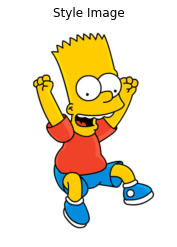

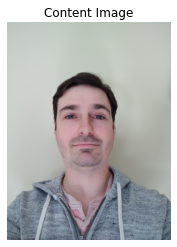

In [17]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None, save_file=False, file_name=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.axis('off')
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated
    if save_file is True:
        if file_name is None:
            raise Exception('must set file_name')
        image.save(str(file_name)+'.png','png')
        files.download(str(file_name)+'.png')


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

#Creating distance functions

From the tutorial: https://pytorch.org/tutorials/advanced/neural_style_tutorial.html

"The principle is simple*: we define two distances, one for the content (D<sub>C</sub>) and one for the style (D<sub>S</sub>). D<sub>C</sub> measures how different the content is between two images while D<sub>S</sub> measures how different the style is between two images. Then, we take a third image, the input, and transform it to minimize both its content-distance with the content-image and its style-distance with the style-image."

but not that simple -  
**why is one distance only picking up content while the other is only picking up style?**

*Note: the input image in most examples is usually the content image. However, an image can be generated from any third image, even white noise.*

In [0]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

**Creating the Style Loss function.**  
A gram matrix is the result of multiplying a given matrix by its transposed matrix. One of the results of this in relation to a CNN is that each channel loses the positional information it would have otherwise had and instead starts to focus on other characteristics in the image.

In [0]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL
                          # b  ,  N
    G = torch.mm(features, features.t())  # compute the gram product
                 #(b, N) * (N, b) --> (b, b)

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

![alt text](https://miro.medium.com/max/2682/1*HeCcGpmxWZFibgLiZCutag.png)

https://towardsdatascience.com/introduction-to-neural-style-transfer-with-tensorflow-99915a5d624a

Let's see if we can get a sense of the gram matrix in action. I have created a similar image to test this on.

In [0]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

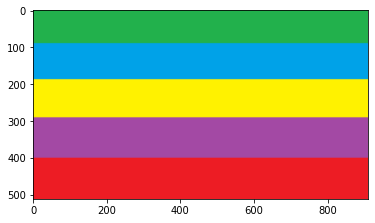

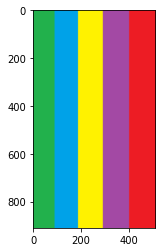

In [0]:
rainbow_img = image_loader('rainbow.png')

plt.figure()
imshow(rainbow_img)

plt.figure()
imshow(rainbow_img.transpose(2,3))

In [0]:
gram_matrix(rainbow_img)

tensor([[0.1602, 0.0896, 0.0414],
        [0.0896, 0.1210, 0.0632],
        [0.0414, 0.0632, 0.0885]], device='cuda:0')

Let's try to get a sense of the resulting matrix. As stated in the code, we took the batch (1) and multiplied it by the color channels (3) to get *b*. We took the dimensions of the image to get *N*. Then we reshaped our tensor to a matrix of (*b*,*N*). In this case, *N* = 512 x 910.

In [0]:
a, b, c, d = rainbow_img.size()
rainbow_features = rainbow_img.view(a * b, c * d) # reshape to (b, N)
rainbow_features.size()

torch.Size([3, 465920])

In [0]:
rainbow_features

tensor([[0.1333, 0.1333, 0.1333,  ..., 0.9294, 0.9294, 0.9294],
        [0.6941, 0.6941, 0.6941,  ..., 0.1098, 0.1098, 0.1098],
        [0.2980, 0.2980, 0.2980,  ..., 0.1412, 0.1412, 0.1412]],
       device='cuda:0')

So now all of the values in each channel are flattened into a single array for each channel. This is what ends up being multiplied by its transpose, and then gets normalized. The result of a matrix multiplied by its transpose will be a symmetric matrix, and that is what we end up with and what we should expect for any values (image).

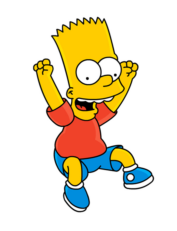

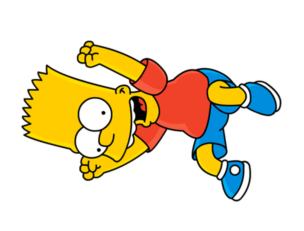

In [20]:
plt.figure()
imshow(style_img)

plt.figure()
imshow(style_img.transpose(2,3))

In [21]:
gram_matrix(style_img)

tensor([[0.2980, 0.2773, 0.2397],
        [0.2773, 0.2704, 0.2427],
        [0.2397, 0.2427, 0.2451]], device='cuda:0')

Here is how the Style Loss function gets defined:

In [0]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

#Building the model.

In [23]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()
#VGG19 is a network pretrained on ImageNet  https://arxiv.org/pdf/1409.1556.pdf

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


"PyTorch’s implementation of VGG is a module divided into two child Sequential modules: features (containing convolution and pooling layers), and classifier (containing fully connected layers). We will use the features module because we need the output of the individual convolution layers to measure content and style loss. Some layers have different behavior during training than evaluation, so we must set the network to evaluation mode using .eval()."

Pytorch Neural Style Transfer tutorial.

In [0]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [0]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

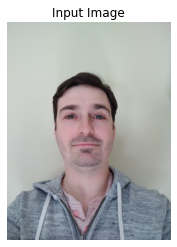

In [26]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [0]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [0]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1,print_state=True):
    """Run the style transfer."""
    #print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)
    if print_state is True: 
      print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if print_state is True:
              if run[0] % 50 == 0:
                  print("run {}:".format(run))
                  print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                      style_score.item(), content_score.item()))
                  print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

#Testing the model with various parameters.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Optimizing..
run [50]:
Style Loss : 1565.357788 Content Loss: 16.526253

run [100]:
Style Loss : 953.468018 Content Loss: 18.231993

run [150]:
Style Loss : 677.349609 Content Loss: 19.662983

run [200]:
Style Loss : 484.993378 Content Loss: 19.466232

run [250]:
Style Loss : 334.759460 Content Loss: 19.766197

run [300]:
Style Loss : 267.238312 Content Loss: 19.897511



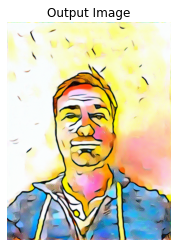

In [29]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img,print_state=True)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
#plt.savefig('neural_net_output.png',format='png')
#files.download('neural_net_output.png')
plt.ioff()
plt.show()

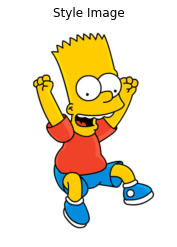

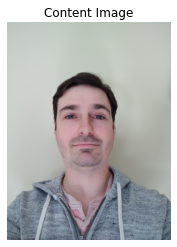

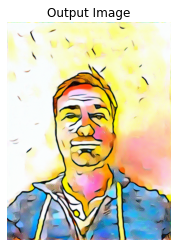

In [30]:
plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

plt.figure()
imshow(output, title='Output Image')

Adjusting the style weight. This is one of various parameters to use to tune the model to get different results.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


weight = 10000


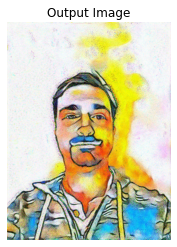

weight = 100000


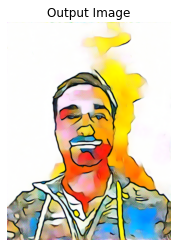

weight = 1000000


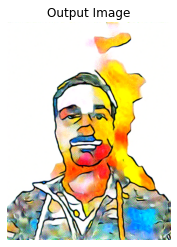

weight = 10000000


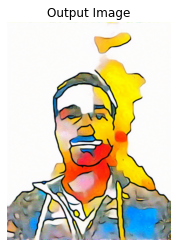

weight = 100000000


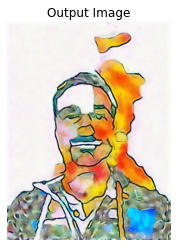

In [31]:
weights = [10000, 100000, 1000000, 10000000, 100000000]
for weight in weights:
  output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, style_weight=weight,print_state=False)
  print('weight =',weight)
  plt.figure()
  imshow(output, title='Output Image')

  # sphinx_gallery_thumbnail_number = 4
  #plt.savefig('neural_net_output.png',format='png')
  #files.download('neural_net_output.png')
  plt.ioff()
  plt.show()

The image does not need to be generated from the content image. It is possible to start with white noise, and then use the content loss function to recreate the content in the output image.  
Generating an image from white noise:

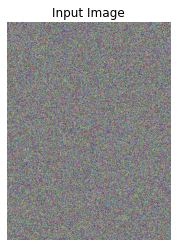

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


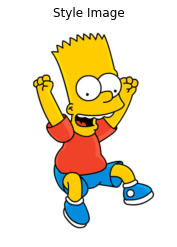

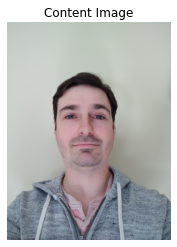

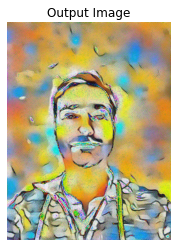

In [32]:
input_img = torch.randn(content_img.data.size(), device=device)
plt.figure()
imshow(input_img, title = 'Input Image')

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img,print_state=False,style_weight=10000)

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
#plt.savefig('neural_net_output.png',format='png')
#files.download('neural_net_output.png')
plt.ioff()
plt.show()

What about generating from white noise with no content? Would this result in an abstract representation of the style image's style?

In [0]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

In [0]:
content_img = image_loader('white.png')

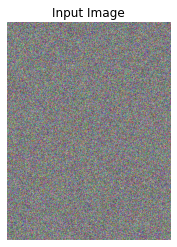

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


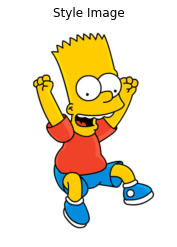

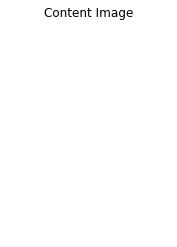

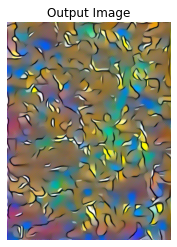

In [38]:
input_img = torch.randn(content_img.data.size(), device=device)
plt.figure()
imshow(input_img, title = 'Input Image')

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img,print_state=False,style_weight=10000)

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
#plt.savefig('neural_net_output.png',format='png')
#files.download('neural_net_output.png')
plt.ioff()
plt.show()

# Segmentation

Segmentation code was adapted from a mix of lecture notes from lectures 8 and 12 in UMBC's DATA 690 along with https://www.learnopencv.com/pytorch-for-beginners-semantic-segmentation-using-torchvision/

We use Resnet101 as our pretrained model for the segmentation part of our project.

In [39]:
# # https://www.learnopencv.com/pytorch-for-beginners-semantic-segmentation-using-torchvision/
# from torchvision import models
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/checkpoints/fcn_resnet101_coco-7ecb50ca.pth


When we came up with the idea for this project, it was intended that it would take selfie-style or candid pictures and transform the people into Simpson versions of themselves. We use Resnet101 to identify and segment the picture. Even though Resnet is capable of producing a large amount (21) of classes, we want it to binarize each pixel by background = 0 and anything else = 1. This allows us to create a mask where background (0) chooses the pixel from the original version of the picture, and anything else (1, the person) chooses the stylized version of the picture.

In [0]:
def mask_extraction(file_name):
  img = Image.open(file_name)
  plt.axis('off')
  plt.imshow(img)
  plt.show()

  # Apply the transformations needed
  trf = transforms.Compose([
                 transforms.Resize((682, imsize)),
                 transforms.ToTensor(), 
                 transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0)

  # Pass the input through the net
  out = fcn(inp)['out']
  # print (out.shape)

  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  # print (om.shape)

  # print (np.unique(om))

  # Define the helper function
  def decode_segmap(image, nc=21):
    label_colors = np.array([(0, 0, 0), (255,255,255)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    
    #this is where we create the binary part of the mask
    idx = image == 0
    r[idx] = label_colors[0, 0]
    g[idx] = label_colors[0, 1]
    b[idx] = label_colors[0, 2]

    idx = image != 0
    r[idx] = label_colors[1, 0]
    g[idx] = label_colors[1, 1]
    b[idx] = label_colors[1, 2] 
      
    rgb = np.stack([r,g,b], axis=2)
    return rgb

  rgb = decode_segmap(om)
  plt.axis('off')
  plt.imshow(rgb)
  plt.show()
  
  return rgb

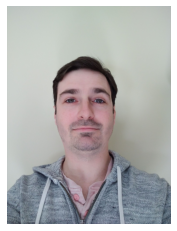

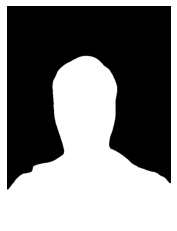

In [45]:
rgb = mask_extraction(get_filename('self.jpg'))

We apply the mask to the original and stylized pictures.

In [48]:
content_img = image_loader('self.jpg')
input_img = content_img.clone()

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, style_weight=10000, print_state=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


In [0]:
def apply_mask(original, styled, mask):
  def transform(ta):
    ta = ta.squeeze(0).clone().cpu().detach().numpy()
    ta = np.moveaxis(ta, 0, -1)
    ta = ta.flatten()
    return ta
  
  original_copy = transform(original)
  styled_copy = transform(styled)
  mask2 = mask.flatten()

  # print(styled_copy.shape)
  # print(original_copy.shape)
  # print (mask2.shape)

  # print(mask2)

  n_array = np.empty(mask2.shape)
  for x in range(mask2.shape[0]):
    if(mask2[x] == 0 ): # background
      n_array[x] = original_copy[x]
    else:
      n_array[x] = styled_copy[x]
  final = n_array.reshape(mask.shape)
  final = np.moveaxis(final, -1, 0)
  final = torch.from_numpy(final).unsqueeze(0)
  final = final.type(torch.float)
  return final

result = apply_mask(content_img, output, rgb)

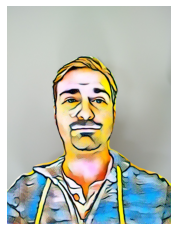

In [72]:
#add commented code if you want to save your file
imshow(result) #, save_file=True, file_name='simpson_self')

# Putting it all together


Now we create a function that wraps everything.

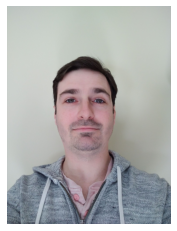

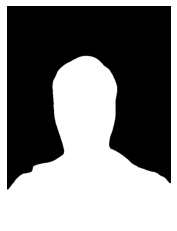

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


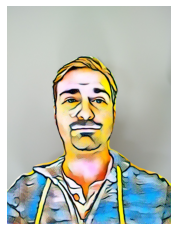

In [69]:
def style_transfer(file_name, style_image_name, weight=1000000):
  mask = mask_extraction(file_name)
  original = image_loader(file_name, False)
  input_img = original.clone()

  style_img = image_loader(style_image_name, False)

  output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            original, style_img, input_img, style_weight=weight,print_state=False)
  
  result = apply_mask(original, output, mask)
  imshow(result)


style_transfer(get_filename('self.jpg'), get_filename('bart.jpg'), weight=10000)